# 🧪 Desafio de Machine Learning: Agrupamento Taxonômico de Espécies Fictícias

Você é um pesquisador em biologia evolutiva e recebeu um conjunto de dados contendo características morfológicas, fisiológicas e comportamentais de 600 espécies *fictícias*.

Seu desafio é aplicar algoritmos de clusterização hierárquica para:

1. Agrupar as espécies com base nas características fornecidas.
2. Visualizar os agrupamentos utilizando dendrogramas.
3. Propor um corte nos agrupamentos e interpretar os "grupos taxonômicos" identificados.
4. Escrever uma análise dos resultados obtidos

## 🧬 Contexto

A classificação taxonômica é uma tarefa central na biologia, usada para entender a relação entre organismos com base em seus traços comuns. O agrupamento hierárquico é um método interpretável que simula a formação de relações evolutivas entre espécies, como em uma árvore filogenética.

Foram gerados no mínimo 10 agrupamentos biológicos. Recomendamos que utilize como "range mínimo dos clusters" valor 10 para aprendizado didático. Realmoços que os dados são sintéticos não refletindo comportamentos ou informações do mundo real.

## Descrição do Dataset

O dataset contém 600 linhas, cada uma representando uma espécie fictícia. Os atributos foram gerados de forma simulada, mas com lógica inspirada na biologia real.

### 📌 Atributos numéricos e booleanos

| Nome                 | Tipo   | Descrição                                           |
| -------------------- | ------ | --------------------------------------------------- |
| `species_id`         | string | Identificador único da espécie (ex: SP001)          |
| `body_mass_kg`       | float  | Massa corporal média da espécie (em kg)             |
| `num_legs`           | int    | Número de membros locomotores (ex: 0, 2, 4, 6)      |
| `has_wings`          | bool   | Possui asas? (1 = sim, 0 = não)                     |
| `tail_length_cm`     | float  | Comprimento médio da cauda (em centímetros)         |
| `eye_count`          | int    | Quantidade de olhos (ex: 0, 2, 4)                   |
| `nocturnal`          | bool   | Ativo durante a noite? (1 = sim, 0 = não)           |
| `avg_lifespan_years` | float  | Expectativa de vida média da espécie (em anos)      |
| `has_venom`          | bool   | Espécie possui veneno ou toxina? (1 = sim, 0 = não) |

### 📌 Atributos categóricos

| Nome              | Tipo   | Descrição                                                       |
| ----------------- | ------ | --------------------------------------------------------------- |
| `diet_type`       | string | Tipo de dieta da espécie: `herbivore`, `carnivore`, `omnivore`  |
| `skin_type`       | string | Tipo de cobertura corporal: `fur`, `scales`, `feathers`, `skin` |
| `social_behavior` | string | Comportamento social: `solitary`, `pair-living`, `group-living` |



# Importações Utilizadas e Dataset Original

In [395]:
# EDA e Visualizacao de Dados
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt

# ML
from sklearn.cluster import AgglomerativeClustering, BisectingKMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

# Otimizacao
import optuna

In [396]:
df = pd.read_csv('datasets/species_dataset.csv')

In [397]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   species_id          600 non-null    object 
 1   body_mass_kg        600 non-null    float64
 2   num_legs            600 non-null    int64  
 3   has_wings           600 non-null    int64  
 4   tail_length_cm      600 non-null    float64
 5   diet_type           600 non-null    object 
 6   eye_count           600 non-null    int64  
 7   skin_type           600 non-null    object 
 8   nocturnal           600 non-null    int64  
 9   avg_lifespan_years  600 non-null    float64
 10  has_venom           600 non-null    int64  
 11  social_behavior     600 non-null    object 
dtypes: float64(3), int64(5), object(4)
memory usage: 56.4+ KB


In [398]:
df.describe()

,body_mass_kg,num_legs,has_wings,tail_length_cm,eye_count,nocturnal,avg_lifespan_years,has_venom
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,49.784101,3.950000,0.285000,45.052394,2.203333,0.380000,120.024664,0.150000
std,19.297540,2.833882,0.451791,9.930405,1.074203,0.485791,0.976676,0.357369
min,5.000000,0.000000,0.000000,16.287173,0.000000,0.000000,117.364032,0.000000
25%,36.107729,2.000000,0.000000,38.446490,2.000000,0.000000,119.366525,0.000000
50%,50.154768,4.000000,0.000000,45.266501,2.000000,0.000000,120.008112,0.000000
75%,62.463348,6.000000,1.000000,51.858016,2.000000,1.000000,120.684532,0.000000
max,127.054630,8.000000,1.000000,72.308672,4.000000,1.000000,123.657702,1.000000


In [399]:
df.head(10)

,species_id,body_mass_kg,num_legs,has_wings,tail_length_cm,diet_type,eye_count,skin_type,nocturnal,avg_lifespan_years,has_venom,social_behavior
0,SP000,59.934283,6,1,27.622702,carnivore,2,fur,0,118.957538,0,pair-living
1,SP001,47.234714,6,1,25.521165,carnivore,4,fur,0,121.226422,0,solitary
2,SP002,62.953771,8,1,50.794426,carnivore,2,fur,0,119.454890,0,pair-living
3,SP003,80.460597,2,1,46.476993,carnivore,4,fur,1,121.522981,0,solitary
4,SP004,45.316933,4,0,40.161889,herbivore,2,scales,0,120.060929,0,group-living
5,SP005,45.317261,4,0,41.685437,omnivore,4,feathers,0,118.593000,1,group-living
6,SP006,81.584256,4,0,47.104705,carnivore,4,fur,1,119.828973,0,pair-living
7,SP007,65.348695,6,1,43.354369,carnivore,2,fur,1,118.937223,0,pair-living
8,SP008,40.610512,6,0,31.594468,omnivore,2,skin,0,120.589349,0,solitary
9,SP009,60.851201,2,1,54.130002,herbivore,2,scales,1,119.738637,0,pair-living


# EDA

## Analisando Distribuição das variáveis apresentadas

In [400]:
# Removendo a coluna species_id
df_eda = df.drop(columns=['species_id'])

In [401]:
# Analisando possibilidade de valores nas colunas categóricas ignorando a coluna species_id
categorical_columns = df_eda.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(f"Valores únicos em {col}: {df_eda[col].unique()}")

Valores únicos em diet_type: ['carnivore' 'herbivore' 'omnivore']
Valores únicos em skin_type: ['fur' 'scales' 'feathers' 'skin']
Valores únicos em social_behavior: ['pair-living' 'solitary' 'group-living']


<Axes: xlabel='diet_type', ylabel='count'>

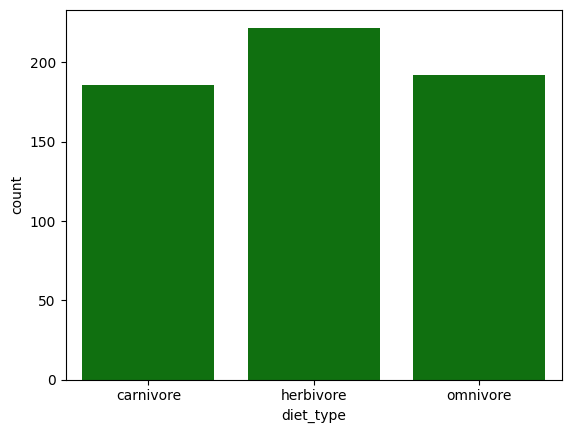

In [402]:
# Verificando distribuição de especies pelo tipo de alimentacao (diet_type)
sns.countplot(data=df_eda, x='diet_type', color='green')

<Axes: xlabel='skin_type', ylabel='count'>

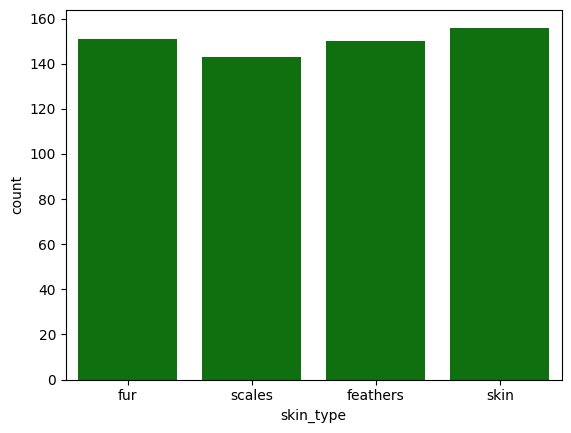

In [403]:
# Verificando distribuição de especies pelo tipo de pele (skin_type)
sns.countplot(data=df_eda, x='skin_type', color='green')

<Axes: xlabel='nocturnal', ylabel='count'>

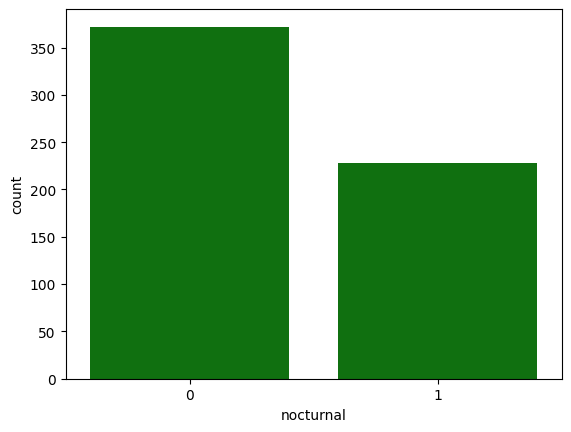

In [404]:
# Verificando a distribuição de especies pelo habito noturno (nocturnal)
sns.countplot(data=df_eda, x='nocturnal', color='green')

<Axes: xlabel='social_behavior', ylabel='count'>

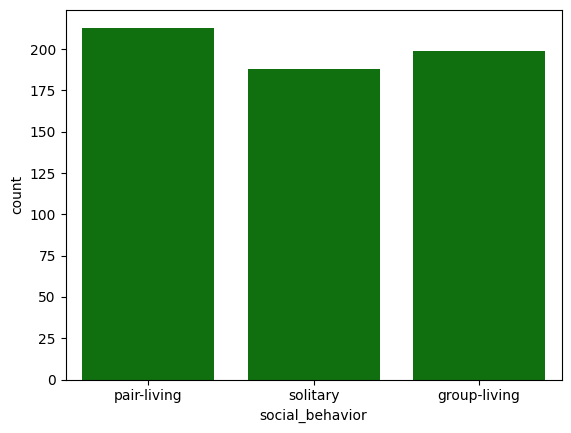

In [405]:
# Verificando distribuição de especies pelo tipo de sociabilidade (social_behavior)
sns.countplot(data=df_eda, x='social_behavior', color='green')

<Axes: xlabel='body_mass_kg', ylabel='Count'>

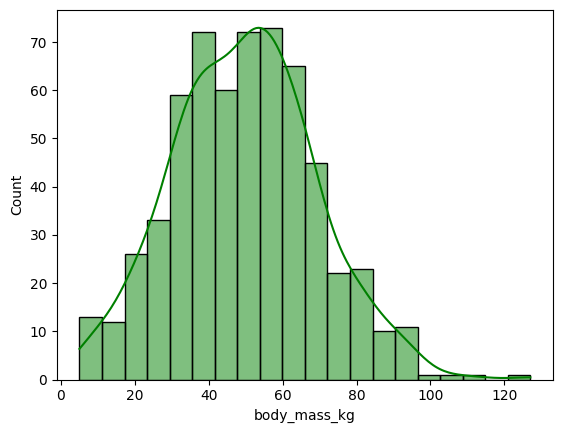

In [406]:
# Distribuição da variável body_mass_kg
sns.histplot(df_eda['body_mass_kg'], kde=True, color='green')

<Axes: xlabel='tail_length_cm', ylabel='Count'>

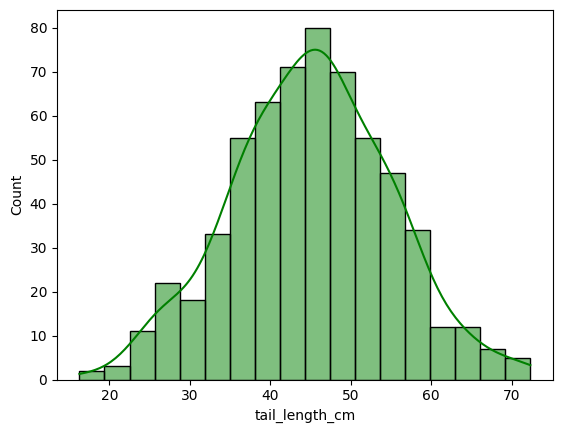

In [407]:
# Distribuição da variável body_mass_kg
sns.histplot(df_eda['tail_length_cm'], kde=True, color='green')

## Box Plot para analise

In [408]:
# Plot de distribuição (Box Plot) por nocturnal e body_mass_kg
px.box(df_eda, x='nocturnal', y='body_mass_kg', color='nocturnal')

In [409]:
# Plot de distribuição (Box Plot) por skin_type e body_mass_kg
px.box(df_eda, x='skin_type', y='body_mass_kg', color='skin_type')

## gráfico de Dispersão das variáveis

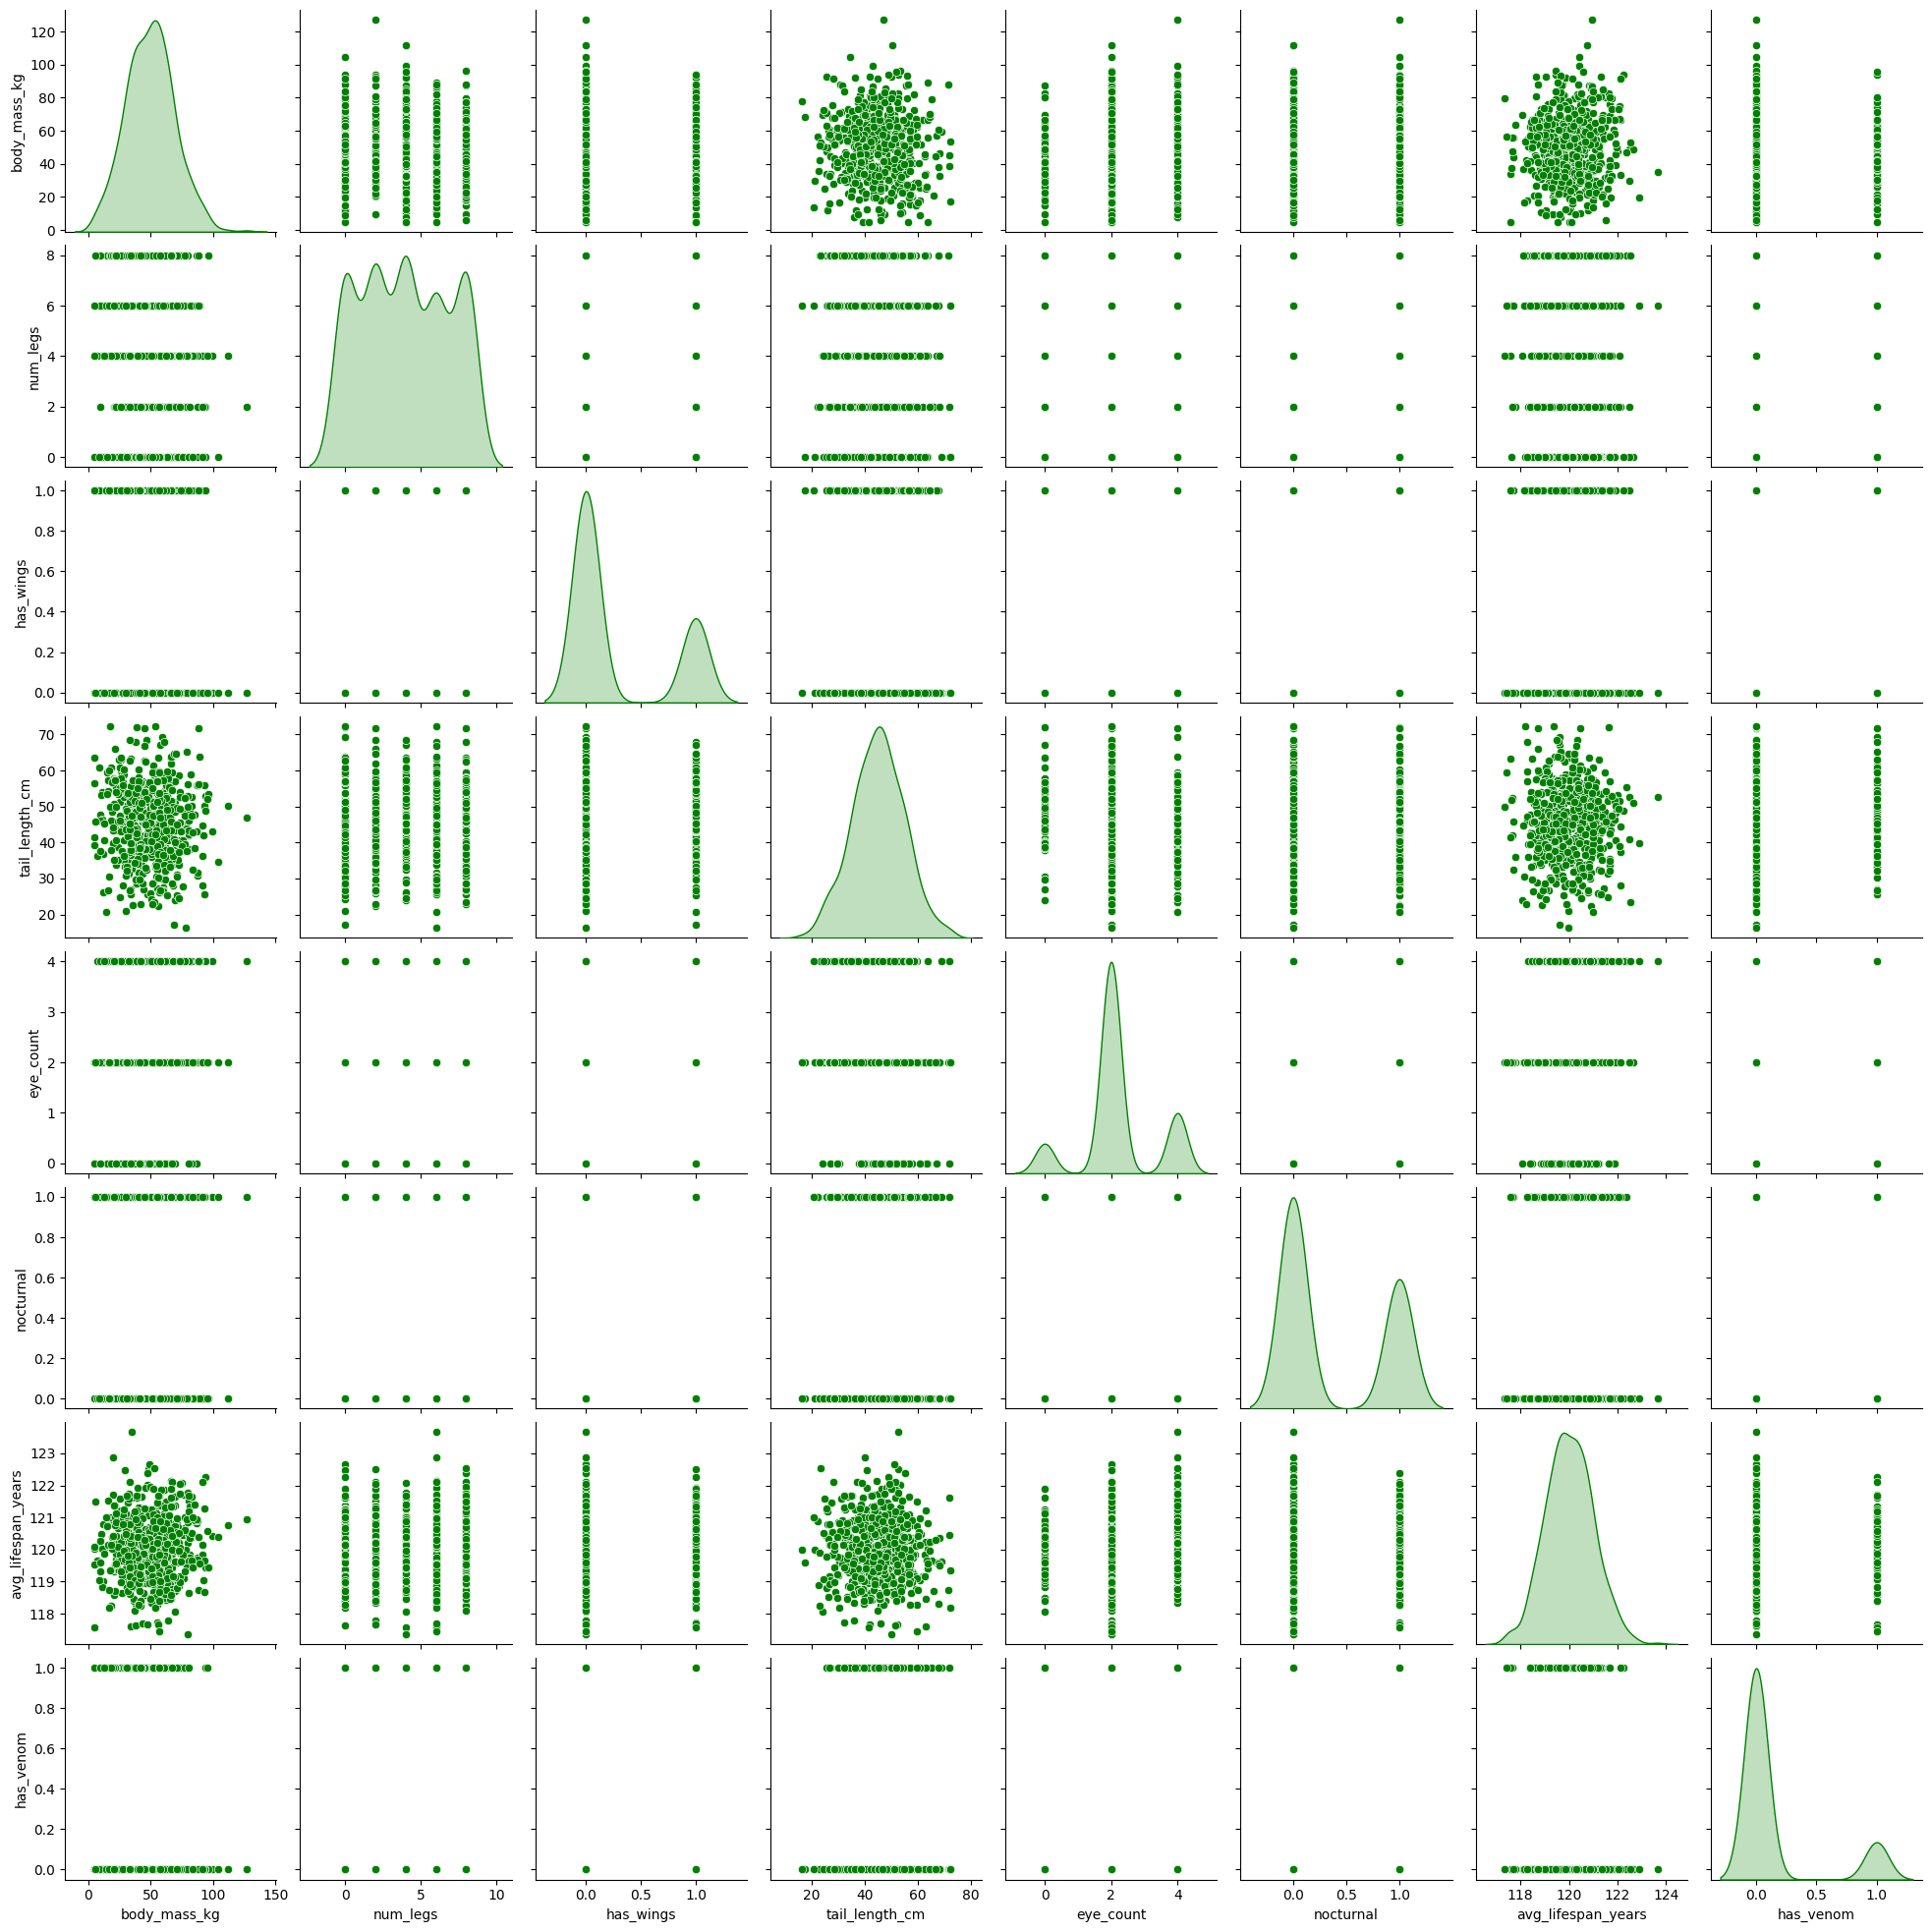

In [410]:
# Gráficos de disperção do dataset
sns.pairplot(df_eda, diag_kind='kde', plot_kws={'color': 'green'}, diag_kws={'color': 'green'})

### Ponderações sobre as variáveis do dataset


- **body_mass_kg**: Apresenta distribuição assimétrica, com concentração de espécies em faixas de massa corporal menores e alguns outliers de massa elevada. Isso sugere a existência de grupos morfologicamente distintos, como pequenos animais e outros de grande porte.

- **num_legs** e **has_wings**: São variáveis discretas, com valores bem definidos. A diversidade nesses atributos pode ser fundamental para separar grupos, como espécies voadoras e terrestres.

- **tail_length_cm**: A maioria das espécies possui caudas curtas, mas há casos de caudas muito longas, indicando possíveis adaptações evolutivas distintas.

- **eye_count**: Os picos em valores como 0, 2 e 4 sugerem adaptações específicas, como espécies cegas ou com múltiplos olhos.

- **nocturnal**: A proporção entre espécies noturnas e diurnas é relevante e pode influenciar fortemente a formação dos agrupamentos.

- **avg_lifespan_years**: A expectativa de vida varia bastante, com predominância de espécies de vida curta, mas também algumas de vida longa, indicando diferentes estratégias de sobrevivência.

- **has_venom**: A maioria das espécies não possui veneno, mas a presença de um grupo pequeno com essa característica pode ser determinante para a separação de clusters.

- **Variáveis categóricas**: Embora não estejam representadas diretamente na matriz de dispersão, atributos como tipo de dieta, tipo de pele e comportamento social são essenciais para a biologia e devem contribuir para a formação de agrupamentos bem definidos.

Essas observações reforçam a importância de normalizar e codificar adequadamente os dados antes da clusterização, além de indicar que a diversidade de variáveis favorece a identificação de grupos taxonômicos distintos.

# Treinar Modelo

In [411]:
# Selecionar as colunas para clusterização
X = df.copy()

# remover colunas desnecessárias
X.drop(columns=['species_id'], axis=1, inplace=True)

In [412]:
X

,body_mass_kg,num_legs,has_wings,tail_length_cm,diet_type,eye_count,skin_type,nocturnal,avg_lifespan_years,has_venom,social_behavior
0,59.934283,6,1,27.622702,carnivore,2,fur,0,118.957538,0,pair-living
1,47.234714,6,1,25.521165,carnivore,4,fur,0,121.226422,0,solitary
2,62.953771,8,1,50.794426,carnivore,2,fur,0,119.454890,0,pair-living
3,80.460597,2,1,46.476993,carnivore,4,fur,1,121.522981,0,solitary
4,45.316933,4,0,40.161889,herbivore,2,scales,0,120.060929,0,group-living
...,...,...,...,...,...,...,...,...,...,...,...
595,39.799672,4,0,55.037095,herbivore,2,scales,0,120.394072,0,group-living
596,44.602501,6,0,66.874888,herbivore,2,fur,1,120.294341,0,solitary
597,30.424726,0,1,32.096355,herbivore,2,fur,0,121.665309,1,pair-living
598,41.114135,0,0,38.510861,omnivore,2,skin,0,118.714197,0,group-living


In [413]:
# Separando variáveis numéricas e categóricas
numeric_features = ['body_mass_kg', 'num_legs', 'tail_length_cm', 'eye_count', 'nocturnal', 'avg_lifespan_years', 'has_venom']
categorical_features = ['diet_type', 'skin_type', 'social_behavior']

In [414]:
# Aplicar as transformações
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

In [415]:
# Criar pre processador de transformacoes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
)

In [416]:
# Transformar os dados
X_transformed = preprocessor.fit_transform(X)
X_transformed


array([[ 0.5264221 ,  0.72399302, -1.75664885, ...,  0.        ,
         1.        ,  0.        ],
       [-0.13221963,  0.72399302, -1.968452  , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.68302273,  1.43032767,  0.57870983, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-1.00404132, -1.39501093, -1.30577243, ...,  0.        ,
         1.        ,  0.        ],
       [-0.44965315, -1.39501093, -0.65928739, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.40255834,  1.43032767,  0.18529609, ...,  0.        ,
         1.        ,  0.        ]])

In [417]:
def hierarchical_aglomerative_objective(trial):
    # Definindo os hiperparâmetros a serem ajustados
    n_clusters = trial.suggest_int('n_clusters', 10, 200)
    linkage = trial.suggest_categorical('linkage', ['ward', 'average', 'complete', 'single'])

    # Instanciar o modelo
    hierquical_model = AgglomerativeClustering(linkage=linkage, n_clusters=n_clusters)

    # Ajustando o modelo com fit predict
    y_predict = hierquical_model.fit_predict(X_transformed)

    # Calcular o silhouette score
    silhouette_avg = silhouette_score(X_transformed, y_predict)

    return silhouette_avg

def hierarchical_divisive_objective(trial):
    # Definindo os hiperparâmetros a serem ajustados
    n_clusters = trial.suggest_int('n_clusters', 10, 200)

    # Instanciar o modelo
    divisive_model = BisectingKMeans(n_clusters=n_clusters)

    # Ajustando o modelo com fit predict
    y_predict = divisive_model.fit_predict(X_transformed)

    # Calcular o silhouette score
    silhouette_avg = silhouette_score(X_transformed, y_predict)

    return silhouette_avg

In [418]:
# Criando um estudo no Optuna

search_space_ag = {"n_clusters": range(10, 200), "linkage": ['ward', 'average', 'complete', 'single']}
sampler_ag = optuna.samplers.GridSampler(search_space_ag)
study_ag = optuna.create_study(direction='maximize', sampler=sampler_ag)

[I 2025-06-20 22:17:19,409] A new study created in memory with name: no-name-16cc27a1-d866-4f1d-b7b2-89b1f54a5422


In [419]:
# Criando um estudo no Optuna

search_space_div = {"n_clusters": range(10, 200)}
sampler_div = optuna.samplers.GridSampler(search_space_div)
study_div = optuna.create_study(direction='maximize', sampler=sampler_div)

[I 2025-06-20 22:17:19,426] A new study created in memory with name: no-name-bd046a2c-154f-4c01-9502-33d194d7d337


In [421]:
# Executar estudo do Optuna Aglomerativo
study_ag.optimize(hierarchical_aglomerative_objective, n_trials=len(search_space_ag['n_clusters']) * len(search_space_ag['linkage']))

[I 2025-06-20 22:17:19,463] Trial 0 finished with value: 0.11174034920910969 and parameters: {'n_clusters': 148, 'linkage': 'complete'}. Best is trial 0 with value: 0.11174034920910969.
[I 2025-06-20 22:17:19,488] Trial 1 finished with value: 0.10093776368188634 and parameters: {'n_clusters': 114, 'linkage': 'complete'}. Best is trial 0 with value: 0.11174034920910969.
[I 2025-06-20 22:17:19,513] Trial 2 finished with value: -0.17322446990537246 and parameters: {'n_clusters': 72, 'linkage': 'single'}. Best is trial 0 with value: 0.11174034920910969.
[I 2025-06-20 22:17:19,537] Trial 3 finished with value: 0.1100915376577939 and parameters: {'n_clusters': 151, 'linkage': 'average'}. Best is trial 0 with value: 0.11174034920910969.
[I 2025-06-20 22:17:19,559] Trial 4 finished with value: -0.18943988688907182 and parameters: {'n_clusters': 124, 'linkage': 'single'}. Best is trial 0 with value: 0.11174034920910969.


[I 2025-06-20 22:17:19,592] Trial 5 finished with value: 0.07576854609485385 and parameters: {'n_clusters': 71, 'linkage': 'complete'}. Best is trial 0 with value: 0.11174034920910969.
[I 2025-06-20 22:17:19,612] Trial 6 finished with value: 0.11321853182300903 and parameters: {'n_clusters': 152, 'linkage': 'complete'}. Best is trial 6 with value: 0.11321853182300903.
[I 2025-06-20 22:17:19,635] Trial 7 finished with value: 0.09622824609913372 and parameters: {'n_clusters': 123, 'linkage': 'average'}. Best is trial 6 with value: 0.11321853182300903.
[I 2025-06-20 22:17:19,659] Trial 8 finished with value: -0.1884011164442173 and parameters: {'n_clusters': 121, 'linkage': 'single'}. Best is trial 6 with value: 0.11321853182300903.
[I 2025-06-20 22:17:19,681] Trial 9 finished with value: -0.14053459829892054 and parameters: {'n_clusters': 155, 'linkage': 'single'}. Best is trial 6 with value: 0.11321853182300903.
[I 2025-06-20 22:17:19,706] Trial 10 finished with value: 0.112461955555348

In [ ]:
# Executar estudo do Optuna Divisivo
study_div.optimize(hierarchical_divisive_objective, n_trials=len(search_space_ag['n_clusters']) * len(search_space_ag['linkage']))

[I 2025-06-20 22:20:02,222] Trial 0 finished with value: 0.047784712757315294 and parameters: {'n_clusters': 39}. Best is trial 0 with value: 0.047784712757315294.
[I 2025-06-20 22:20:02,347] Trial 1 finished with value: 0.051399951280007655 and parameters: {'n_clusters': 35}. Best is trial 1 with value: 0.051399951280007655.
[I 2025-06-20 22:20:02,455] Trial 2 finished with value: 0.04195303716160841 and parameters: {'n_clusters': 68}. Best is trial 1 with value: 0.051399951280007655.
[I 2025-06-20 22:20:02,610] Trial 3 finished with value: 0.002853848200220063 and parameters: {'n_clusters': 189}. Best is trial 1 with value: 0.051399951280007655.
[I 2025-06-20 22:20:02,732] Trial 4 finished with value: 0.03995705315522033 and parameters: {'n_clusters': 91}. Best is trial 1 with value: 0.051399951280007655.
[I 2025-06-20 22:20:02,875] Trial 5 finished with value: 0.016175173898661577 and parameters: {'n_clusters': 148}. Best is trial 1 with value: 0.051399951280007655.
[I 2025-06-20 22

In [422]:
# Mostrar melhor configuração do Optuna (Divisive)
best_params_ag = study_ag.best_params
best_value_ag = study_ag.best_value
print(f"Clusters = {best_params_ag['n_clusters']}")
print(f"Melhor valor (Aglomerativo): {best_value_ag}")

Clusters = 197
Melhor valor (Aglomerativo): 0.14449627054338715


In [423]:
# Mostrar melhor configuração do Optuna (Divisive)
best_params_div = study_div.best_params
best_value_div = study_div.best_value
print(f"Clusters = {best_params_div['n_clusters']}")
print(f"Melhor valor (Divisivo): {best_value_div}")

Clusters = 10
Melhor valor (Divisivo): 0.07539370440486995


In [424]:
# Criar o Modelo com melhor configuração (Aglomerative)
best_model = AgglomerativeClustering(
    n_clusters=best_params_ag['n_clusters'],
    linkage=best_params_ag['linkage']
)
best_model.fit(X_transformed)

AgglomerativeClustering(n_clusters=197)

In [425]:
# Verificar silhouette score do modelo
best_silhouette_avg = silhouette_score(X_transformed, best_model.labels_)
print(f"Silhouette Score do modelo: {best_silhouette_avg}")

Silhouette Score do modelo: 0.14449627054338715


In [426]:
# Criar coluna com cluster escolhido no DataFrame original
df['cluster'] = best_model.labels_

# Visualizar Resultados do treinamento

In [427]:
# Mostrar Chart com Trials do Optuna
fig = optuna.visualization.plot_optimization_history(study_ag)
fig.show()

In [428]:
# Mostrar Chart com Trials do Optuna
fig = optuna.visualization.plot_optimization_history(study_div)
fig.show()

In [429]:
# Treinar modelo com Scipy
modelo_de = linkage(X_transformed, method=best_params_ag['linkage'], optimal_ordering=True)

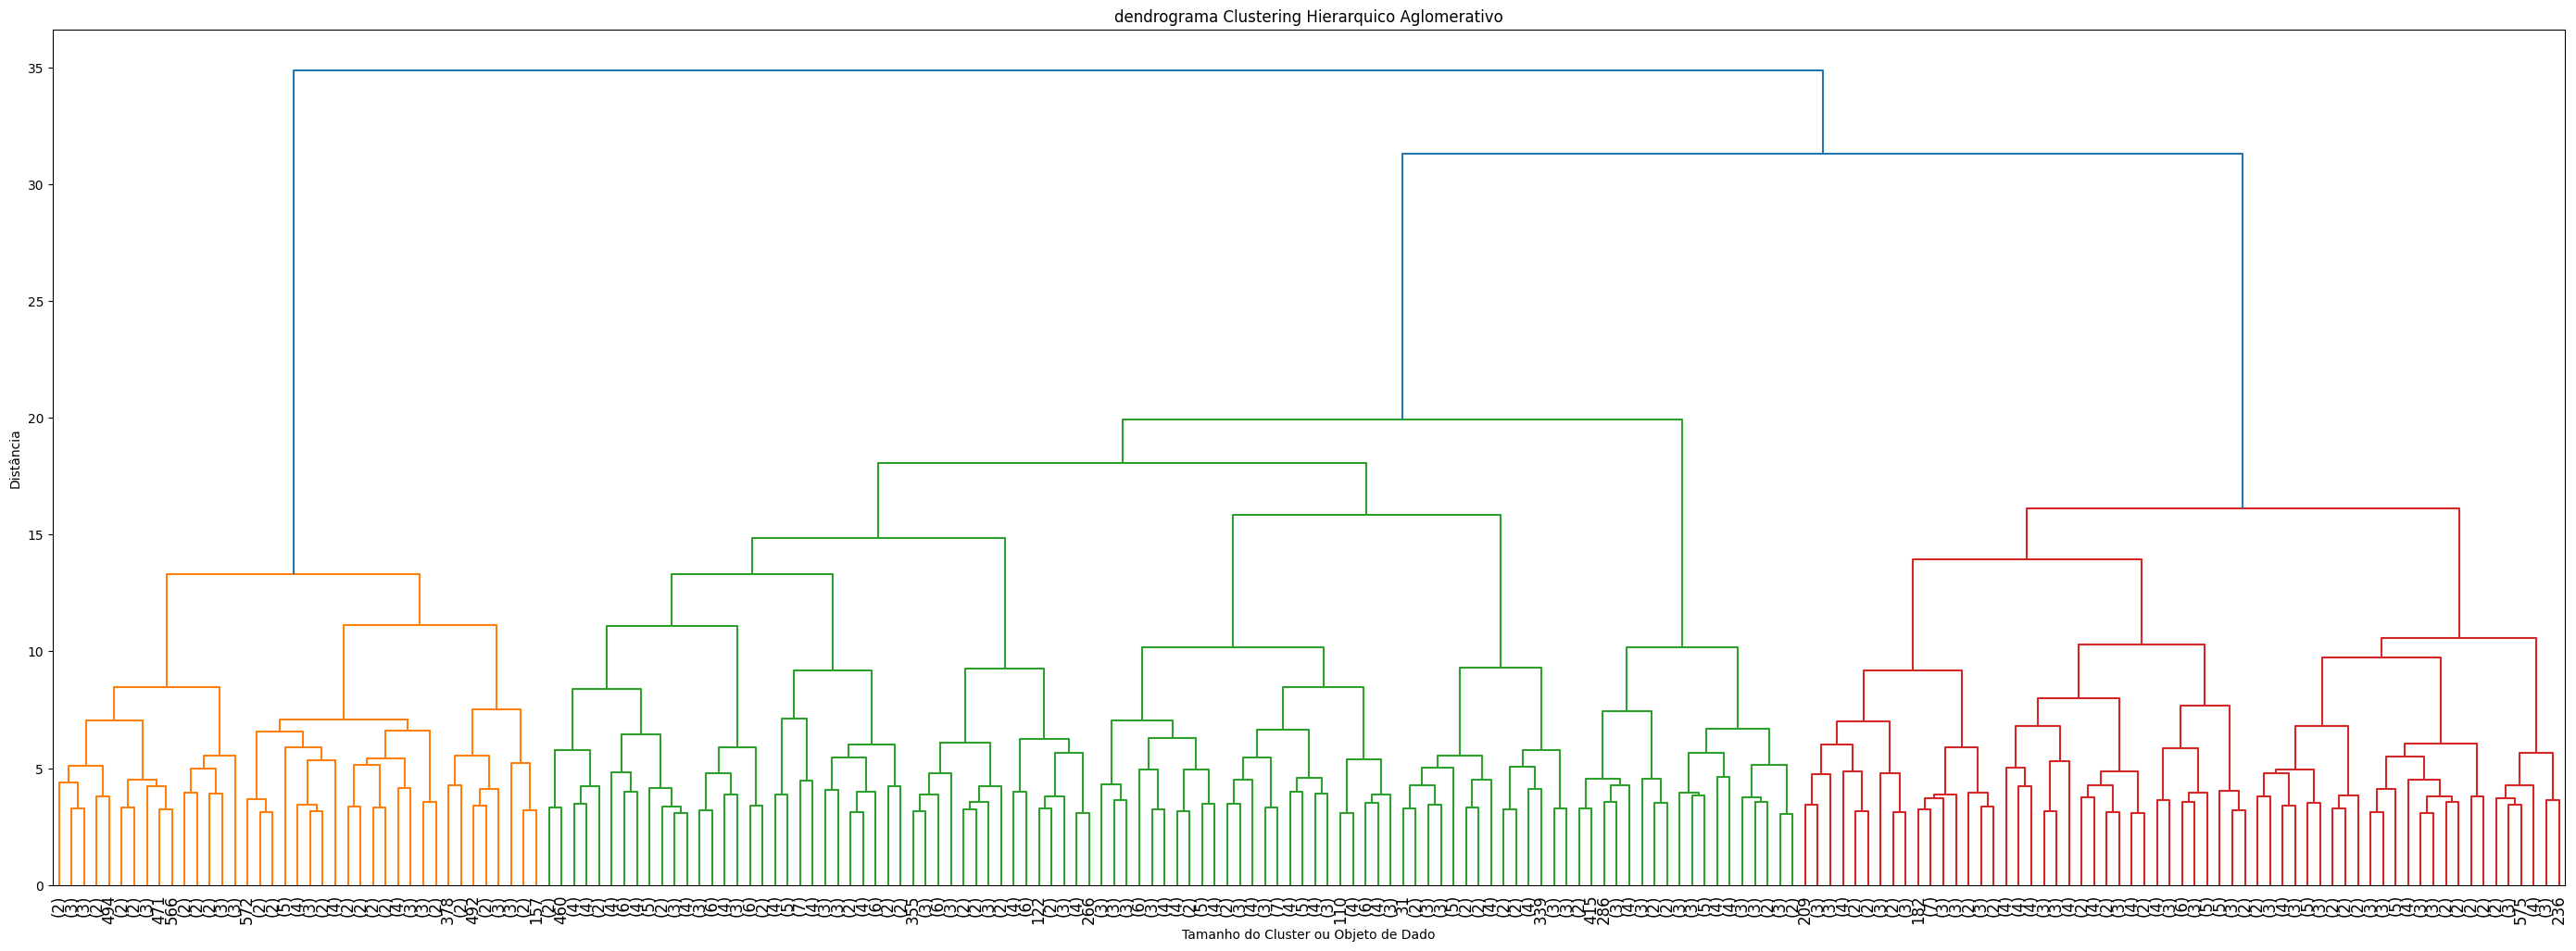

In [430]:
# Mostrar Dendrograma
plt.figure(figsize=(35, 12))
dendrogram(modelo_de, truncate_mode='lastp', p=200, leaf_rotation=90, leaf_font_size=12)
plt.title('dendrograma Clustering Hierarquico Aglomerativo')
plt.xlabel('Tamanho do Cluster ou Objeto de Dado')
plt.ylabel('Distância')
plt.show()

In [431]:
# Cortar o Dendrograma
cluster_de_scipy = cut_tree(modelo_de, height=1)
len(np.unique(cluster_de_scipy))

576

## Cruzamentos utilizando classificação dos clusters

In [436]:
# Cruzamento entre skin_type e body_mass_kg, apresentando os clusters
px.scatter(df, x='skin_type', y='body_mass_kg', color='cluster')

In [437]:
# Cruzamento entre diet_type e body_mass_kg, apresentando os clusters
px.scatter(df, x='diet_type', y='body_mass_kg', color='cluster')

In [438]:
# Cruzamento entre diet_type e has_venom, apresentando os clusters
px.scatter(df, x='diet_type', y='has_venom', color='cluster')

In [439]:
# Cruzamento entre num_legs e body_mass_kg, apresentando os clusters
px.scatter(df, x='num_legs', y='body_mass_kg', color='cluster')

In [435]:
# Distribuicao da variavel cluster
qtde_cluster = df.value_counts('cluster')
px.bar(qtde_cluster, color=qtde_cluster.index)

# Conclusão do Projeto

A análise de clusterização hierárquica aplicada ao conjunto de espécies fictícias permitiu identificar agrupamentos taxonômicos distintos, baseados em características morfológicas, fisiológicas e comportamentais. No entanto, o valor do Silhouette Score obtido foi relativamente baixo, indicando que a separação entre os grupos não é tão clara e que há sobreposição significativa entre os clusters formados.

O dendrograma gerado mostra a formação de grupos, mas a distribuição dos tamanhos dos clusters revela que muitos deles possuem poucos indivíduos, o que pode ser reflexo da alta variabilidade dos dados sintéticos e da dificuldade do algoritmo em encontrar fronteiras bem definidas.

Os cruzamentos entre variáveis, como `skin_type` x `body_mass_kg`, `diet_type` x `body_mass_kg` e `num_legs` x `body_mass_kg`, mostram que alguns padrões são capturados, mas a distinção entre os grupos não é tão evidente quanto seria desejável para uma análise taxonômica robusta.

O histórico de otimização do Silhouette Score reforça essa limitação, já que mesmo após a busca por diferentes configurações de hiperparâmetros, os valores permaneceram baixos. Isso é comum em datasets sintéticos, mas indica que os agrupamentos encontrados devem ser interpretados com cautela.

Em resumo, embora o método de clusterização hierárquica tenha permitido explorar a estrutura dos dados e identificar possíveis agrupamentos, os resultados sugerem que a segmentação obtida não é fortemente representativa. Para análises futuras, pode ser interessante testar outros métodos de agrupamento ou realizar uma seleção de variáveis mais criteriosa para tentar melhorar a separação entre